# Neural Network with one hidden layer
In this notebook I will implement a neural network with one hidden layer. This NN will then be used to classify the digital figures from [MNIST database](http://yann.lecun.com/exdb/mnist/). The output layer would be activated using "softmax" since the output is not just 0 or 1. 

## 1. Packages

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# load data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [51]:
# data dims
print('training set dimensions: ' + str(x_train.shape))
print('training label dimensions: ' + str(y_train.shape))
print('test set dimensions: ' + str(x_test.shape))
print('test label dimensions: ' + str(y_test.shape))

training set dimensions: (60000, 28, 28)
training label dimensions: (60000,)
test set dimensions: (10000, 28, 28)
test label dimensions: (10000,)


### 1.1 helper functions
- sigmoid
- relu
- softmax
- sigmoid backward
- relu backward
- softmax backward

In [250]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)), x
def relu(x):
    return np.maximum(0, x), x
def softmax(x):
    xx = x-x.max()
    return np.exp(xx) / np.sum(np.exp(xx), axis=0, keepdims=True), x

In [251]:
# test helper functions
x = np.random.randn(2, 5)
y, cache = softmax(x)

print('x.shape = ' + str(x.shape))
print('y.shape = ' + str(y.shape))

x.shape = (2, 5)
y.shape = (2, 5)


In [54]:
def sigmoid_backward(dA, cache):
    """
    The backward version of sigmoid function, converting dL/dA to dL/dZ
    
    Args:
    dA -- Derivative of cost function with respect to A, dL/dA
    cache -- activation_cache, Z
    
    Returns:
    dZ -- Derivative of cost function with respect to Z, dA * (dA/dZ)
    """
    
    Z = cache
    A, _cache = sigmoid(Z)
    
    dAdZ = A * (1 - A)
    dZ = dA * dAdZ
    
    return dZ 

In [55]:
# test
dA = np.array([1, 2]).reshape((2, 1))
cache = np.array([1, 1]).reshape((2, 1))
dZ = sigmoid_backward(dA, cache)
print(dZ)

[[0.19661193]
 [0.39322387]]


In [56]:
def relu_backward(dA, cache):
    """
    The backward version of relu function, converting dL/dA to dL/dZ
    
    Args:
    dA -- Derivative of cost function with respect to A, dL/dA
    cache -- activation_cache, Z
    
    Returns:
    dZ -- Derivative of cost function with respect to Z, dA * (dA/dZ)
    """
    
    Z = cache
    
    dAdZ = Z >= 0
    dZ = dA * dAdZ
    
    return dZ

In [57]:
# test
dA = np.array([1, 2]).reshape((2, 1))
cache = np.array([1, 1]).reshape((2, 1))
dZ = relu_backward(dA, cache)
print(dZ)

[[1]
 [2]]


**Derivative of softmax function:**

Softmax function is defined as:

$$ S(Z) = \frac{\exp Z}{\sum_i \exp z_i} $$ 

where Z is a column vector $\left[\begin{smallmatrix}z_1\\.\\.\\.\\z_n \end{smallmatrix}\right]$.

The derivative of softmax function is:

$$ \frac{\partial S_i}{\partial Z_j} = \begin{cases} S_i(1-S_j) & i \neq j \\ -S_iS_j & i = j \end{cases}$$

This can be written in a more compact way:

$$ \frac{\partial S_i}{\partial Z_j} = S_i(\delta_{ij} - S_j) $$

If we define a broadcast version of $S$, whose shape is (n, 1), as $S^b$ with shape (n, n), where $S^b_{ij}=S_i$. Equivalently, $S^b_{ji}=S_j$. Since $S^b_{ji} = (S^b)^T_{ij}$, the derivative can be rewritten in matrix form:

$$ \frac{\partial S}{\partial Z} = S^b (I - (S^b)^T) $$

$ \frac{\partial S}{\partial Z} $ has shape (n, n). Up to now, we have assumed that S is a column vector with shape (n, 1). In a real application, we need to vectorize the computation for multiple training samples, then S will be of shape (n, m). The shape of $ \frac{\partial S}{\partial Z} $ will be (n, n, m). 

To implement the vectorized calculation, we first broadcast S to S' with shape (n, n, m), where $S'(i, j, k) == S(i, k)$. Note that the computation for $S^b$ in the equation above is still valid for $S'$, except the transpose since we now have a 3-dimensional matrix. Here, we only take the transpose on the first two axes, leaving the 3rd dimension unchanged. 

$ \frac{\partial S}{\partial Z} $ with shape (n, n, m) then needs to be used for computing $\frac{\partial L}{\partial Z}$, where $L$ is the loss function of the model, by:

$$ \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial S} \frac{\partial S}{\partial Z} $$

again dimension analysis, $ \frac{\partial L}{\partial Z} $ has shape (n, m), $ \frac{\partial L}{\partial S} $ has shape (n, m), $ \frac{\partial S}{\partial Z} $ has shape (n, n, m). We use Einstein sum (np.einsum) to do this computation as (ik, ijk -> jk) to obtain $ \frac{\partial L}{\partial Z} $ of shape (n, m).

In [58]:
def softmax_backward(dA, cache):
    """
    The backward version of softmax function, converting dL/dA to dL/dZ 
    
    Args:
    dA -- Derivative of cost function with respect to A, dL/dA
    cache -- activation_cache, Z
    
    Returns:
    dZ -- Derivative of cost function with respect to Z, dA * (dA/dZ)
    """
    
    Z = cache
    A, _cache = softmax(Z)
    
    n, m = Z.shape
    
    Ab = np.broadcast_to(np.expand_dims(A, axis=1), (n, n, m)) # broadcast matrix A for vectorized computation
    AbT = np.transpose(Ab, axes=[1, 0, 2]) # transpose the first 2 axes    
    I = np.identity(n)
    Ib = np.broadcast_to(np.expand_dims(I, axis=2), (n, n, m))
    
    dAdZ = Ab * (Ib - AbT)
    
    # dA - (n, m)
    # dAdZ - (n, n, m)
    dZ = np.einsum('ik, ijk -> jk',   dA , dAdZ)
    
    return dZ

In [59]:
dA = np.random.randn(2, 4)
cache = np.random.randn(2, 4)
softmax_backward(dA, cache)

array([[ 0.0965267 ,  0.00696673,  0.02414509,  0.01036988],
       [-0.03584462, -0.01716364, -0.02286152, -0.3106002 ]])

### test softmax backward

In [165]:
Z = np.array([1, 2, 3, 4]).reshape((4, 1))
A, cache = softmax(Z)
Y = np.array([0, 0, 1, 0]).reshape((4, 1))

In [166]:
dA = - Y/A

In [167]:
dZ = softmax_backward(dA, Z)

In [168]:
dZ

array([[ 0.0320586 ],
       [ 0.08714432],
       [-0.76311718],
       [ 0.64391426]])

## 2. Initialize parameters

In [60]:
def initialize_parameters(layer_dims):
    """
    Initialize the parameters W's and b's.
    
    Argument:
    layer_dims -- an array of layer dimensions [n0, n1, ..., nL]
    
    Returns:
    parameters -- a dictionary of initialized parameters
                    W1: random
                    b1: zeros
                    ...
                    WL: random
                    bL: zeros
    """
    parameters = {}
    L = len(layer_dims) - 1
    for l in range(0, L):
        parameters['W'+str(l+1)] = np.random.randn(layer_dims[l+1], layer_dims[l]) * 0.01
        parameters['b'+str(l+1)] = np.zeros((layer_dims[l+1], 1))
    
    return parameters

In [61]:
# test initialize_parameters()
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
print(parameters)

{'W1': array([[ 2.32250951e-03, -1.41330849e-03,  1.53493922e-02,
        -3.41875301e-04,  2.81046192e-02],
       [ 4.26460426e-03, -9.56055238e-03, -3.45585704e-04,
        -1.51748050e-03,  1.40295434e-02],
       [-9.74701231e-03,  8.93891403e-03, -1.40447513e-02,
         2.03216436e-02, -2.64978169e-03],
       [-7.13123573e-03, -1.00383172e-02, -1.27359826e-02,
         9.21584587e-06, -2.69977082e-03]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[ 0.0005891 , -0.01011546,  0.02496523, -0.00260117]]), 'b2': array([[0.]])}


## 3. Forward propagation

In [62]:
# linear forward
def linear_forward(A_prev, W, b):
    """
    The linear part of forward propagation: Z = WA + b
    
    Argument:
    A_prev -- the activitions of previous step (X for the first hidden layer)
    W, b -- parameters 
    
    Returns:
    Z -- result of linear forward propagation
    cache -- cache A_prev and the parameters W and b for convenience when calculating backpropagation
    """
    
    Z = W @ A_prev + b
    cache = (A_prev, W, b)
    
    return Z, cache

In [63]:
# test linear forward
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
A_prev = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
W = parameters['W1']
b = parameters['b1']
Z, cache = linear_forward(A_prev, W, b)
print('Z: ' + str(Z))
print('cache: ' + str(cache))

Z: [[ 0.01531117]
 [-0.00145869]
 [ 0.06627346]
 [-0.06658928]]
cache: (array([[1],
       [2],
       [3],
       [4],
       [5]]), array([[-6.99215352e-03,  2.60902500e-03,  4.63233218e-03,
        -9.77979137e-03,  8.46148871e-03],
       [ 9.31404769e-03, -9.43436747e-05,  6.26160176e-03,
        -7.02047639e-03, -2.57390975e-04],
       [ 2.00680757e-02,  5.51606103e-03,  4.04266822e-03,
        -7.60821937e-03,  1.06956280e-02],
       [ 2.14783427e-03, -5.58118132e-04, -1.51217944e-02,
         1.47858133e-02, -1.62797506e-02]]), array([[0.],
       [0.],
       [0.],
       [0.]]))


In [64]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Forward propagation including both linear mapping and activation
    
    Argument:
    A_prev -- the activations of previous step (X for the first hidden layer)
    W, b -- parameters
    activation -- activation function used in this layer
    
    Returns:
    A -- The activation values of current layer
    cache -- A tuple containing both caches from linear part and activation part, (linear_cache, activation_cache)
                where linear_cache is (A_prev, W, b), and activation_cache is Z
    """
    
    assert(W.shape[1]==A_prev.shape[0])
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == 'relu':        
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'softmax':
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [189]:
# test linear_activation_forward
layer_dims = [5, 4, 1]
parameters = initialize_parameters(layer_dims)
A_prev = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
W = parameters['W1']
b = parameters['b1']
A, cache = linear_activation_forward(A_prev, W, b, activation='relu')
print("A: " + str(A))
print("cache: " + str(cache))

A: [[0.14119504]
 [0.17185106]
 [0.        ]
 [0.        ]]
cache: ((array([[1],
       [2],
       [3],
       [4],
       [5]]), array([[ 1.06598244e-02,  5.98888751e-03,  1.32266946e-02,
         9.72867180e-03,  7.99253427e-03],
       [-1.05900787e-02,  1.01312824e-02,  2.06294928e-02,
         8.17826228e-04,  1.94037588e-02],
       [ 3.70293003e-03, -1.59178088e-03, -1.05235848e-02,
         3.15753806e-03, -7.72343064e-03],
       [-5.98971566e-03,  1.21650836e-02, -1.06929208e-02,
        -1.22663508e-02,  7.82467729e-05]]), array([[0.],
       [0.],
       [0.],
       [0.]])), array([[ 0.14119504],
       [ 0.17185106],
       [-0.05703839],
       [-0.06241248]]))


In [188]:
W

array([[ 0.00501261,  0.00380598,  0.00512525, -0.01401253,  0.01814257],
       [-0.02207838,  0.01404174,  0.0016276 , -0.00527018, -0.009393  ],
       [ 0.01976955, -0.0085519 , -0.0061324 ,  0.00619611, -0.01525609],
       [ 0.00069867,  0.00346226, -0.01570748,  0.00297798,  0.00301298]])

In [194]:
def L_model_forward(X, parameters):
    """
    Use current parameters to calculate the output layer value AL.
    
    Arguments:
    X -- input data
    parameters -- a dictionary containing W and b
    
    Returns:
    AL -- output layer values 
    caches -- a list of cache, returned by linear_activation_forward() at each layer
    """
    
    caches = []
    L = int(len(parameters) / 2)
    A_prev = X
    for l in range(1, L):
        A_prev, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation='sigmoid')
        caches.append(cache)
    
    
    # Last layer
    AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], activation='softmax')
    caches.append(cache)
    
    return AL, caches

In [67]:
layer_dims = [5, 4, 3]
parameters = initialize_parameters(layer_dims)
X = np.array([1, 2, 3, 4, 5]).reshape((5, 1))
AL, caches = L_model_forward(X, parameters)
print('AL: ' + str(AL))
print('caches: ' + str(len(caches)))

AL: [[0.33294258]
 [0.33354824]
 [0.33350918]]
caches: 2


## 4. Compute cost

In [68]:
def compute_cost(AL, Y):
    """
    Compute the cost function of softmax activation
    
    Argument:
    AL -- hypothesis of the model
    Y -- training labels
    
    Returns:
    cost -- the value of cost function
    """
    m = AL.shape[1]
    cost = -1/m * np.sum(Y*np.log(AL))
    cost = np.squeeze(cost)
    return cost 

In [69]:
layer_dims = [5, 4, 3]
parameters = initialize_parameters(layer_dims)
X = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]).reshape((5, 2))
Y = np.array([1, 0, 0, 0, 0, 1]).reshape((3, 2))
AL, caches = L_model_forward(X, parameters)
cost = compute_cost(AL, Y)
print('cost: ' + str(cost))

cost: 1.7928384245030298


### Understand softmax cost function

The cost function of softmax function is:

$$ J(A, Y) = - \frac{1}{m} \sum_j^m\sum_i^n y_i^{(j)}\log a_i^{(j)}$$

where $A = \left[\begin{smallmatrix} a_1^{(1)} & .. & a_1^{(m)} \\ .&.&. \\ a_n^{(1)} & .. & a_n^{(m)} \end{smallmatrix} \right]$, $Y = \left[\begin{smallmatrix} y_1^{(1)} & .. & y_1^{(m)} \\ .&.&. \\ y_n^{(1)} & .. & y_n^{(m)} \end{smallmatrix} \right]$

For training sample (j), the loss function is 

$$ J( a^{(j)}, y^{(j)}) = -\sum_i^n y_i^{(j)}\log a_i^{(j)} $$

Take an exponential of the RHS

$$ \exp\left(\sum_i^n y_i^{(j)}\log a_i^{(j)}\right) = \prod_i^n (a_i^{(j)})^{-y_i^{(j)}}$$

Since there is only one $y_i^{(j)}$ for a certain (j) which is 1, whereas all others are 0, we can minimize the loss function by setting the corresponding $a_i^{(j)}$ large. This is equivalent to the goal of making $a_i^{(j)}$ and $y_i^{(j)}$ equal. 

## 5. Backward propagation

**Linear part back propagation:**

Convert the derivative of cost function with respect to $Z$, the neuron value before activation, $\frac{\partial L}{\partial Z}$, to the derivative with respect to parameters $W$ and $b$, 

In [135]:
def linear_backward(dZ, cache):
    """
    Linear part of the backward propagation: 
    dW = 1/m * dZ * dA_prev.T (n[l], n[l-1]) (n[l], m) (n[l-1], m)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    Args:
    dZ -- derivative of cost function with respect to Z
    cache -- cache from linear forward propagation, (A, W, b)
    
    Returns:
    dW, db -- gradients used for gradient descent
    """
    
    m = dZ.shape[1]
    A_prev = cache[0]
    
    dW = 1/m * dZ @ A_prev.T
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    
    
    return dW, db 

In [71]:
dZ = np.array([1, 2, 3]).reshape((3, 1))
cache = (np.random.randn(4, 1), 0, 0)
dW, db = linear_backward(dZ, cache)
print('dW: ' + str(dW))

dW: [[ 1.21388892  1.85144802 -1.15620048  0.39800219]
 [ 2.42777784  3.70289604 -2.31240096  0.79600439]
 [ 3.64166676  5.55434406 -3.46860144  1.19400658]]


In [72]:
def linear_activation_backward(dA, cache, activation):
    """
    Linear + activation parts, whole backward propagation dA -> dA_prev
    
    Args:
    dA -- derivative of cost function with respect to A
    cache -- cache from linear activation forward propagation, (linear_cache, activation_cache)
    
    Returns:
    dW, db -- gradients used for gradient descent
    """
    linear_cache, activation_cache = cache
    W = linear_cache[1]
    
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'softmax':
        dZ = softmax_backward(dA, activation_cache)
    
    dA_prev = W.T @ dZ
    
    dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [73]:
dA = np.array([1, 2, 3]).reshape((3, 1))
cache = ((np.random.randn(4, 1), np.random.randn(3, 4), 0), np.random.randn(3, 1))
dA_prev, dW, db = linear_activation_backward(dZ, cache, 'relu')
print('dW: ' + str(dW))

dW: [[-0.4207154   0.65934649  0.05163552 -0.45783475]
 [-0.8414308   1.31869299  0.10327105 -0.9156695 ]
 [-1.26214619  1.97803948  0.15490657 -1.37350424]]


In [191]:
def L_model_backward(AL, Y, caches):
    """
    Args:
    AL -- activation values of the last layer
    Y -- data labels
    caches -- a list of caches from each layer, layer one cache corresponds to caches[0]
    
    Returns:
    grads -- a dict of gradients (of loss function wrt parameters) in each layer, will be used to update the parameters.
    """
    
    assert(Y.shape == AL.shape)
    assert((AL != 0).all())
    grads = {}
    m = Y.shape[1]
    dAL = - (Y / AL)
    m = Y.shape[1]
    L = len(caches)
    
    cache = caches[L-1]
#     print('AL='+ str(AL))
    grads['dA'+str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = linear_activation_backward(dAL, cache, 'softmax')    
    
    for l in reversed(range(L-1)):
        grads['dA'+str(l)], grads['dW'+str(l+1)], grads['db'+str(l+1)] = linear_activation_backward(grads['dA'+str(l+1)], caches[l], 'sigmoid')
        
    return grads

In [181]:
A != 0

array([[ True],
       [ True],
       [ True],
       [ True]])

## 6. Update parameters

Update parameters W and b using the grads value returned by ```linear_activation_backward()```.

In [203]:
def update_parameters(parameters, grads, learning_rate):
    """
    Args:
    parameters -- current parameter W and b
    grads -- gradients of loss function wrt W and b 
    learning_rate -- rate of gradient descent
    
    Returns:
    parameters -- updated W and b
    """

    L = len(parameters) // 2
    
    for l in range(L):    
        parameters['W' + str(l+1)] -= learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] -= learning_rate * grads['db' + str(l+1)]
    
    return parameters

In [76]:
# test update_parameters

## 7. Test model

**transform Y**

The given Y has shape (1, 60000), where each column corresponds to the label digit of its corresponding image. In our learning algorithm, we use softmax to activate the last layer in order to get 10 output and compute a reasonable cost. Previously, I have been using Y with shape (1, 60000) directly for ```L_model_backward()``` but no error occured. It was because the (1, 60000) matrix was automatically broadcast to (10, 60000) which is the shape of AL.

Therefore, I add one more assertion to avoid this bug to ```L_model_backward()```: 

```python
assert(Y.shape == AL.shape)
```

In order to make the learning algorithm work, I need to transform Y to a (10, 60000) matrix, where the numbers in the original array indicate the row locations of 1's in the new matrix.

**Iterate the model**

In [192]:
def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations=1000, print_cost=False):
    L = len(layer_dims) - 1
    n0, m = X.shape
    parameters = initialize_parameters(layer_dims)
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
#         print('AL.shape: ' + str(AL.shape))
        
        grads = L_model_backward(AL, Y, caches)
#         print('grads: ' + str(grads))
        parameters = update_parameters(parameters, grads, learning_rate)
#         print('parameters updated')
        cost = compute_cost(AL, Y)
        if print_cost and i % 10 == 0:
            print('Iteration {0} cost: {1}'.format(i, cost))
#             print('AL: ' + str(AL))
    return parameters

In [253]:
m = x_train.shape[0]
r, c = x_train.shape[1], x_train.shape[1]
X = x_train.reshape((m, r*c))
X = X.T
Y1 = y_train.reshape((1, m))
n, m = 10, Y1.shape[1]
Y = np.zeros((n, m))
Y[Y1, np.arange(m)] = 1
layer_dims = [r*c, 20, 10]
parameters = L_layer_model(X, Y, layer_dims, learning_rate=0.02, num_iterations=1000, print_cost=True)

Iteration 0 cost: 2.3000857205811975
Iteration 10 cost: 2.2747131245164827
Iteration 20 cost: 2.245573708892367
Iteration 30 cost: 2.211095257017025
Iteration 40 cost: 2.171216846565133
Iteration 50 cost: 2.1278788947722354
Iteration 60 cost: 2.0826484328856956
Iteration 70 cost: 2.0374711319266114
Iteration 80 cost: 1.9923208861108583
Iteration 90 cost: 1.947391381808716
Iteration 100 cost: 1.9029706973368135
Iteration 110 cost: 1.859363859061456
Iteration 120 cost: 1.8166929927555078
Iteration 130 cost: 1.7752090656844708
Iteration 140 cost: 1.7349960236978912
Iteration 150 cost: 1.6960243466374294
Iteration 160 cost: 1.6583329454500144
Iteration 170 cost: 1.622583030240086
Iteration 180 cost: 1.5889682590831908
Iteration 190 cost: 1.554682390654763
Iteration 200 cost: 1.5221368081384536
Iteration 210 cost: 1.4914358697084447
Iteration 220 cost: 1.4629776423611665
Iteration 230 cost: 1.4318216472807381
Iteration 240 cost: 1.4049837422893443
Iteration 250 cost: 1.3820081168783036
Iter

In [254]:
parameters

{'W1': array([[-0.01078314, -0.01047815,  0.00673244, ...,  0.01084923,
          0.00692201, -0.0057775 ],
        [-0.00836306, -0.00770925,  0.00698634, ...,  0.00262784,
         -0.01173791,  0.00210835],
        [-0.00615542,  0.00854349, -0.01742107, ...,  0.00927265,
         -0.00068873,  0.00160297],
        ...,
        [ 0.01070821,  0.00487171,  0.00148207, ...,  0.00563985,
         -0.01046456, -0.02628802],
        [ 0.00251906, -0.01134621, -0.00463086, ..., -0.00281211,
         -0.00998264, -0.01022773],
        [ 0.0040811 , -0.00761623,  0.01848787, ...,  0.00907349,
          0.00242964, -0.00521692]]),
 'b1': array([[ 1.00837745e-04],
        [-5.20284952e-04],
        [-2.90167012e-04],
        [ 3.91866838e-04],
        [-3.51017601e-04],
        [-1.69597544e-04],
        [ 4.90965003e-04],
        [-8.45840388e-05],
        [-9.31288621e-04],
        [ 1.34999738e-04],
        [-1.82012903e-04],
        [-2.49311336e-04],
        [ 3.41523291e-04],
        [ 

**Numerical instability**
When iterating softmax classification, we encountered numerical instability where np.exp overflows. This happens typically because the Z values sometimes get too large. To avoid this, we look at the formula for computing softmax again:

$$ S_j = \frac{\exp z_j}{\sum_i \exp z_i}$$

if we multiply the numerator and denominator both with a constant real number C, the formula becomes

$$ S_j = \frac{C\exp z_j}{\sum_i C\exp z_i}  = \frac{\exp z_j+\log C}{\sum_i \exp z_i + \log C}$$

The overflow of $\exp z_j$ is cause by large $z_j$. We see in the above equation that by adding a same constant to all $z$'s does not influence the output value of softmax function. Therefore, we modify the softmax function as follows: 

$$ S_j = \frac{\exp z_j - \max(Z)}{\sum_i \exp z_i - \max(Z)}$$

<del>This turns out not very helpful.</del> The issue is the definition of the ```softmax()```. After changing it, the algorithm starts to learn.

In [255]:
X_test = np.transpose(x_test, axes=[1, 2, 0]).reshape((28*28, 10000))
A, cache = L_model_forward(X_test, parameters)

4
[0.01822289 0.02357232 0.0120256  0.01872075 0.43431835 0.0591388
 0.01819358 0.06369247 0.13205727 0.22005797]


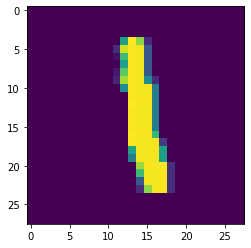

In [260]:
index = 6
print(np.argmax(A[:, index]))
print(A[:, index])
plt.imshow(X[:, index].reshape((r, c)))

In [280]:
def predict_softmax(X_test, Y_test, parameters):
    """
    Test the accuracy of model's prediction.
    
    Args:
    X_test -- input features of the dataset to be tested
    Y_test -- labels of the dataset ot be tested
    parameters -- parameters of the trained model
    
    Returns:
    predictions -- a prediction array of the output, have the same shape as Y_test
    """
    assert(X_test.shape[1] == Y_test.shape[1])
    
    m = X_test.shape[1]
    A, cache = L_model_forward(X_test, parameters)
    predictions = np.argmax(A, axis=0)
    check = predictions == Y_test
    num_correct = np.nonzero(check)[0].shape[0]
    accuracy = num_correct / m
    print('Accuracy: ' + str(accuracy))
    return predictions

In [281]:
X_test = np.transpose(x_test, axes=[1, 2, 0]).reshape((28*28, 10000))
Y_test = y_test.reshape((1, len(y_test)))
predictions = predict_softmax(X_test, Y_test, parameters)

Accuracy: 0.901


In [282]:
predictions

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

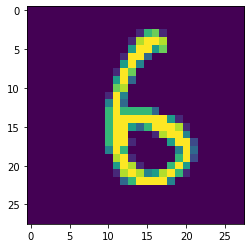

In [295]:
index = 3000
plt.imshow(x_test[index, :, :])

In [296]:
predictions[index]

6

In [269]:
np.nonzero(np.array([True, True, True, False]))[0].shape[0]

3

In [107]:
Y.shape

(1, 60000)